In [1]:
import os
import time
import ollama
import pandas as pd

In [2]:
def messages_from_prompt(prompt):
    messages = []
    with open(f"prompts/{prompt}", "r", encoding="utf-8") as f:
        lines = f.readlines()
    
    for line in lines:
        role = line.split(" ")[0]
        content = line[len(role)+1:]
        messages.append({"role": role, "content": content})
    return messages

In [3]:
# for all prompts evaluate the model

# all the text files in the prompts directory
prompts = [f for f in os.listdir("prompts") if f.endswith(".txt")]
models = ["openchat", "mistral", "llama2", "gemma", "openhermes"]

time_str = time.strftime("%Y-%m-%d_%H-%M-%S")
time_df = pd.DataFrame(columns=["model", "prompt", "time_per_char", "time_init", "time_total"])

for model in models:
    print(f"Model: {model}")
    ollama.chat(
        model=model,
        messages=[],
        stream=False
    )
    for prompt in prompts:
        print(f"Prompt: {prompt}")
        messages = messages_from_prompt(prompt)
        response = ""
        first_chunk = True
        start = time.time()
        stream = ollama.chat(
            model=model,
            messages=messages,
            stream=True
        )
        for chunk in stream:
            if first_chunk:
                before_stream = time.time()
                first_chunk = False
            response += chunk['message']['content']
            print(response, end="\r")
        end = time.time()
        time_df = pd.concat([time_df, pd.DataFrame([{
            "model": model,
            "prompt": prompt,
            "time_per_char": (end - before_stream) / len(response),
            "time_init": before_stream - start,
            "time_total": end - start
        }])])
        print(f"Time: {end - start}")
        with open(f"responses/{model}_chat_{time_str}_{prompt}", "w", encoding="utf-8") as f:
            f.write(response)
        time.sleep(1)

# write the time df to a file
with open("time_df.csv", "w") as f:
    time_df.to_csv(f, index=False)

Model: openchat
Prompt: prompt_1.txt
 Bien sûr ! Pacte Novation est un groupe avec différentes filiales spécialisées dans le domaine des systèmes d'information, experts, embarqués et édition de logiciels. L'entreprise intervient dans les secteurs industriel, transport, énergie, banque et assurance.
 Bien sûr ! Pacte Novation est un groupe avec différentes filiales spécialisées dans le domaine des systèmes d'information, experts, embarqués et édition de logiciels. L'entreprise intervient dans les secteurs industriel, transport, énergie, banque et assurance.

 Bien sûr ! Pacte Novation est un groupe avec différentes filiales spécialisées dans le domaine des systèmes d'information, experts, embarqués et édition de logiciels. L'entreprise intervient dans les secteurs industriel, transport, énergie, banque et assurance.

 Bien sûr ! Pacte Novation est un groupe avec différentes filiales spécialisées dans le domaine des systèmes d'information, experts, embarqués et édition de logiciels. L'en

C:\Users\echriston\AppData\Local\Temp\ipykernel_5320\567298032.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  time_df = pd.concat([time_df, pd.DataFrame([{


Prompt: prompt_2.txt
 Bien sûr, je peux vous raconter une histoire vraie sur les moustiques. 
 Bien sûr, je peux vous raconter une histoire vraie sur les moustiques. 

 Bien sûr, je peux vous raconter une histoire vraie sur les moustiques. 

 Bien sûr, je peux vous raconter une histoire vraie sur les moustiques. 

 Bien sûr, je peux vous raconter une histoire vraie sur les moustiques. 

 Bien sûr, je peux vous raconter une histoire vraie sur les moustiques. 

 Bien sûr, je peux vous raconter une histoire vraie sur les moustiques. 

 Bien sûr, je peux vous raconter une histoire vraie sur les moustiques. 

 Bien sûr, je peux vous raconter une histoire vraie sur les moustiques. 

 Bien sûr, je peux vous raconter une histoire vraie sur les moustiques. 

 Bien sûr, je peux vous raconter une histoire vraie sur les moustiques. 

 Bien sûr, je peux vous raconter une histoire vraie sur les moustiques. 

 Bien sûr, je peux vous raconter une histoire vraie sur les moustiques. 

 Bien sûr, je peux

## Analysis

### Time

In [4]:
# read csv file

time_df = pd.read_csv("time_df.csv")
print(time_df.head())

      model        prompt  time_per_char  time_init  time_total
0  openchat  prompt_1.txt       0.005014   0.339259    2.008854
1  openchat  prompt_2.txt       0.005112   0.130823    4.997096
2  openchat  prompt_3.txt       0.005048   0.128915    1.663406
3  openchat  prompt_4.txt       0.005326   0.142895    4.249037
4  openchat  prompt_5.txt       0.005452   0.127368    5.159938


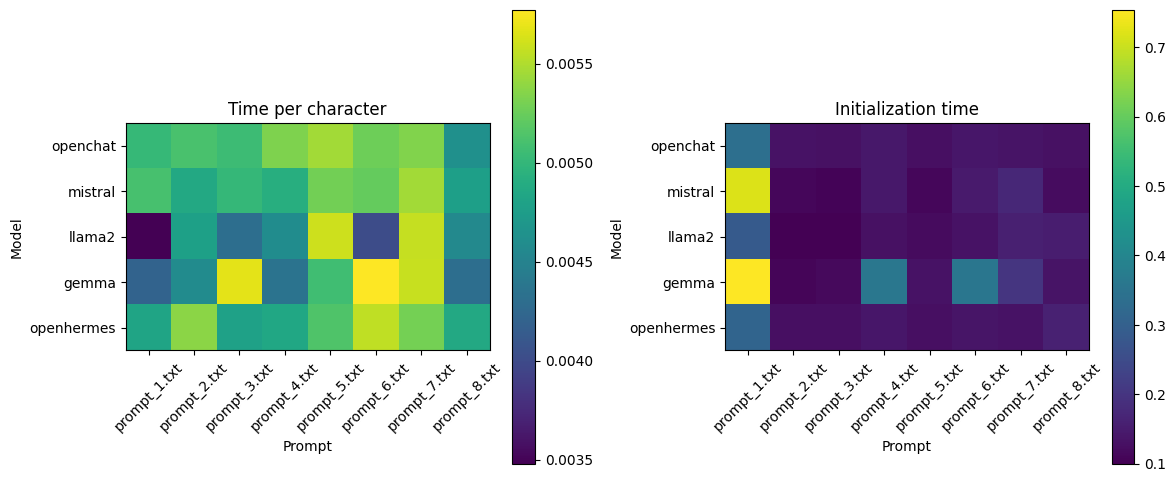

In [5]:
# plot the time per character distribution for each model
import matplotlib.pyplot as plt

prompts = [f for f in os.listdir("prompts") if f.endswith(".txt")]
models = ["openchat", "mistral", "llama2", "gemma", "openhermes"]

# build a matrix of EVERY_FEATURE for each model for each prompt
time_per_char_matrix = []
time_init_matrix = []
for model in models:
    time_per_char = []
    time_init = []
    for prompt in prompts:
        time_per_char.append(time_df[(time_df["model"] == model) & (time_df["prompt"] == prompt)]["time_per_char"].values[0])
        time_init.append(time_df[(time_df["model"] == model) & (time_df["prompt"] == prompt)]["time_init"].values[0])
    time_per_char_matrix.append(time_per_char)
    time_init_matrix.append(time_init)


# plot the matrices like heatmaps
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(time_per_char_matrix, cmap="viridis")
ax[0].set_xticks(range(len(prompts)))
ax[0].set_yticks(range(len(models)))
ax[0].set_xticklabels(prompts, rotation=45)
ax[0].set_yticklabels(models)
ax[0].set_title("Time per character")
ax[0].set_xlabel("Prompt")
ax[0].set_ylabel("Model")

ax[1].imshow(time_init_matrix, cmap="viridis")
ax[1].set_xticks(range(len(prompts)))
ax[1].set_yticks(range(len(models)))
ax[1].set_xticklabels(prompts, rotation=45)
ax[1].set_yticklabels(models)
ax[1].set_title("Initialization time")
ax[1].set_xlabel("Prompt")
ax[1].set_ylabel("Model")

plt.colorbar(ax[0].imshow(time_per_char_matrix, cmap="viridis"), ax=ax[0])
plt.colorbar(ax[1].imshow(time_init_matrix, cmap="viridis"), ax=ax[1])
plt.tight_layout()
plt.show()

### French

In [6]:
import langdetect
import numpy as np

In [7]:
# for each response, find the language of each sentence

responses = [f for f in os.listdir("responses") if f.endswith(".txt")]
lang_df = pd.DataFrame(columns=["model", "sentence", "lang"])

for response in responses:
    with open(f"responses/{response}", "r", encoding="utf-8") as f:
        text = f.read()
    
    model = response.split("_")[0]

    sentences = text.split(".")
    for sentence in sentences:
        try:
            lang = langdetect.detect(sentence)
        except:
            continue
        
        lang_df = pd.concat([lang_df, pd.DataFrame([{ "model": model, "sentence": sentence, "lang": lang }])])

In [8]:
print(lang_df.head())

   model                                           sentence lang
0  gemma  Je suis un robot assistant et je suis là pour ...   fr
0  gemma   Je suis informé sur les services que propose ...   fr
0  gemma   L'entreprise intervient dans les secteurs Ind...   fr
0  gemma  Je suis désolé, mais je n'ai pas la capacité d...   fr
0  gemma   Je suis un robot assistant spécialisé en aide...   fr


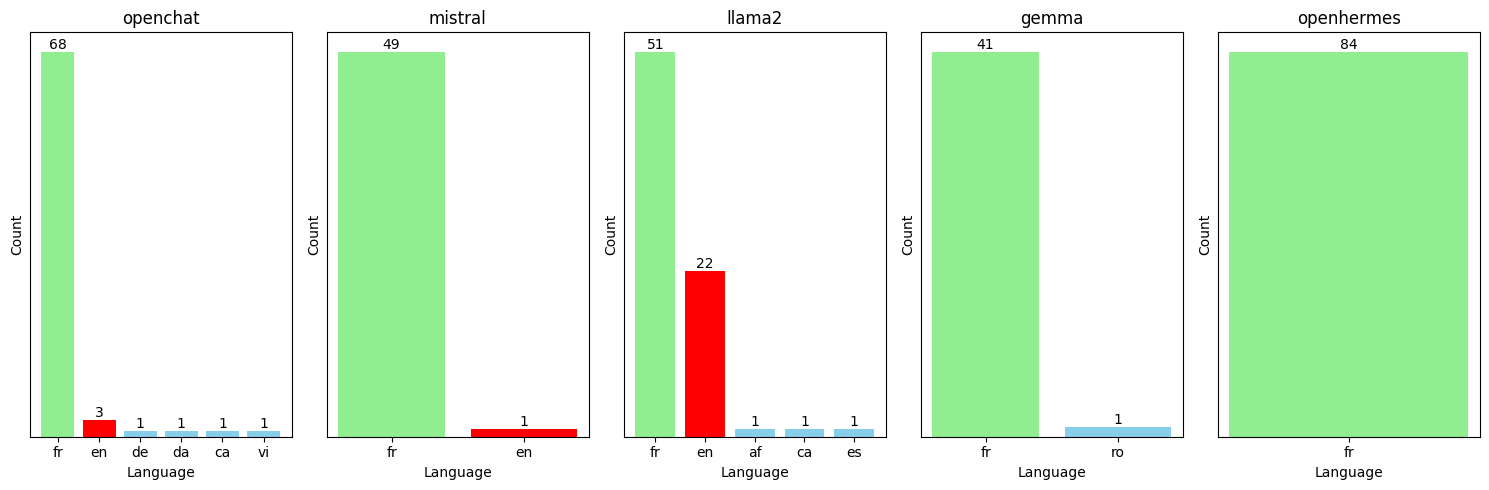

In [9]:
# plot the languages for each model
fig, ax = plt.subplots(1, len(models), figsize=(15, 5))
color_dict = {"fr": "lightgreen", "en": "red", "unknown": "lightgrey"}
for i, model in enumerate(models):
    sub_df = lang_df[lang_df["model"] == model]
    # color sky blue or light green if french
    ax[i].bar(sub_df["lang"].value_counts().index, sub_df["lang"].value_counts().values, color=[color_dict[lang] if lang in color_dict else "skyblue" for lang in sub_df["lang"].value_counts().index])
    # add text count on top of each bar
    for j, count in enumerate(sub_df["lang"].value_counts().values):
        ax[i].text(j, count, str(count), ha="center", va="bottom")
    ax[i].set_title(model)
    ax[i].set_xlabel("Language")
    ax[i].set_ylabel("Count")
    # no y ticks
    ax[i].set_yticks([])
    
plt.tight_layout()
plt.show()


In [10]:
# print some non french sentences (and non unknown)

for model in models:
    print(f"Model: {model}")
    sub_df = lang_df[(lang_df["model"] == model) & (lang_df["lang"] != "fr") & (lang_df["lang"] != "unknown")]
    print(sub_df)
    print("\n\n")

Model: openchat
      model                        sentence lang
0  openchat                   McDonald's\n2   en
0  openchat                  Burger King\n3   de
0  openchat                    Udemy (udemy   da
0  openchat     Oracle Java Tutorials (docs   ca
0  openchat                          oracle   en
0  openchat                  GitHub (github   vi
0  openchat   Stack Overflow (stackoverflow   en



Model: mistral
     model                                           sentence lang
0  mistral   Let me know if you would like to hear the sum...   en



Model: llama2
    model                                           sentence lang
0  llama2  Pleasure to assist you! Pacte Novation is a gr...   en
0  llama2   They operate in various sectors such as indus...   en
0  llama2   Is there anything specific you would like to ...   en
0  llama2  Ah, excellent choix ! Les moustiques sont vrai...   en
0  llama2   From the frozen tundras of the Arctic to the ...   en
0  llama2                  